In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

import shap

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model_name, model, X, y):
    
    predictions_probas = model.predict_proba(X)[:,1]
    predictions = model.predict(X)

    Accuracy = accuracy_score(y, predictions)
    F1 = f1_score(y, predictions)
    AUC = roc_auc_score(y, predictions_probas)
    LogLoss = log_loss(y, predictions_probas)

    print('Accuracy for', model_name, ': %1.3f' % Accuracy)
    print('F score for', model_name, ': %1.3f' % F1)
    print('AUC for', model_name, ': %1.4f' % AUC)
    print('LogLoss for', model_name, ': %1.3f' % LogLoss)

    metrics_table = pd.DataFrame({'Accuracy' : [round(Accuracy, 3)],
                                  'F score' : [round(F1, 3)], 
                                  'AUC' : [round(AUC, 4)], 
                                  'LogLoss' : [round(LogLoss, 3)]}, index = [model_name])
    
    return metrics_table

In [3]:
model_comparison = pd.read_csv('../../data/airlines/model_comparison.csv', )
model_comparison.rename(columns = {'Unnamed: 0' : 'Model'}, inplace = True)

In [4]:
model_comparison = model_comparison.sort_values(by = ['AUC', 'LogLoss'], ascending = [False, True])

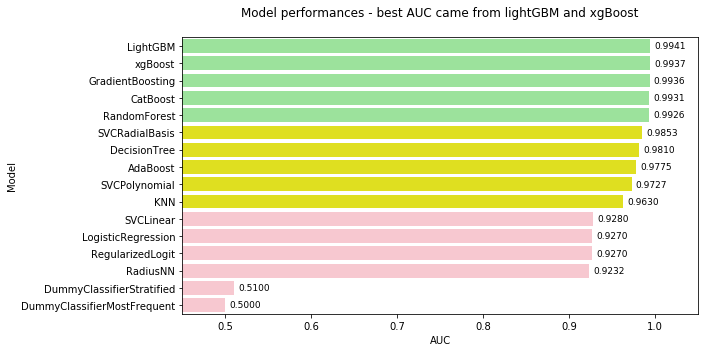

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))

g = sns.barplot(x = 'AUC', y = 'Model', data = model_comparison, ax = ax,
                palette = ['lightgreen' if (x > 0.99) else ('yellow' if (x > 0.96) else 'pink') for x in model_comparison['AUC']])

for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2, 
            '{:1.4f}'.format(width), ha = 'left', va = 'center', size = 9) 
    
plt.title('Model performances - best AUC came from lightGBM and xgBoost\n')
plt.tight_layout()
plt.xlim(0.45, 1.05)
plt.show()

LightGBM has the highest AUC scores among all models. I'll use SHAP to interpret and explain what it does

In [13]:
# one hot encoded Xs
X_train = pd.read_csv('../../data/airlines/X_train.csv')
X_test = pd.read_csv('../../data/airlines/X_test.csv')

#Ys
y_train = np.array(pd.read_csv('../../data/airlines/y_train.csv'))
y_test = np.array(pd.read_csv('../../data/airlines/y_test.csv'))

### Explaining lightGBM's feature importances, dependencies and effects

In [14]:
pkl_filename = 'saved_models/LightGBM.pkl'

with open(pkl_filename, 'rb') as file:
    LGB = pickle.load(file)

Re-evaluate preformance on test set

In [15]:
evaluate_model('LGB', LGB, X_test, y_test)

Accuracy for LGB : 0.961
F score for LGB : 0.956
AUC for LGB : 0.9941
LogLoss for LGB : 0.102


,Accuracy,F score,AUC,LogLoss
LGB,0.961,0.956,0.9941,0.102


#### Use SHAP values to interpret model

In [16]:
shap.initjs()

In [17]:
LGB_explainer = shap.TreeExplainer(model = LGB, data = X_train, model_output = 'probability')
LGB_shap_values = LGB_explainer.shap_values(X_train)

100%|===================| 9976/10000 [06:59<00:01]        

Here the raw output would be the log odds. Dealing with it:
1. e^x = predicted probability - calculating manually using np.exp()
2. Setting model output to probability, then the predicted probability will be explained, not how the log odds were changing

#### 1. Variable Importances

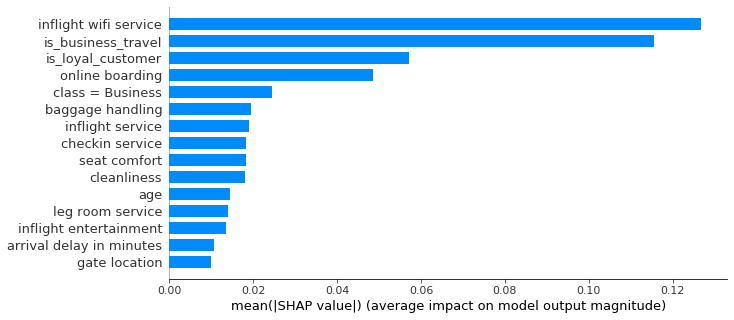

In [23]:
shap.summary_plot(LGB_shap_values, X_train, plot_type = 'bar', plot_size = (10, 5), max_display = 15)

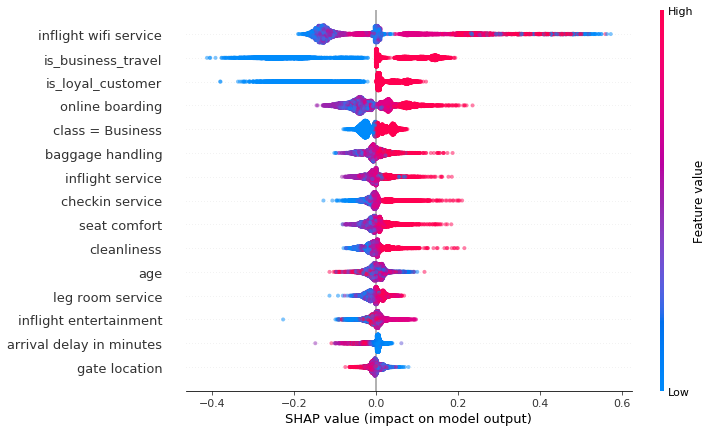

In [24]:
shap.summary_plot(LGB_shap_values, X_train, plot_type = 'dot', plot_size = (10, 7), alpha = 1/2, max_display = 15)

#### 2. Dependence plots

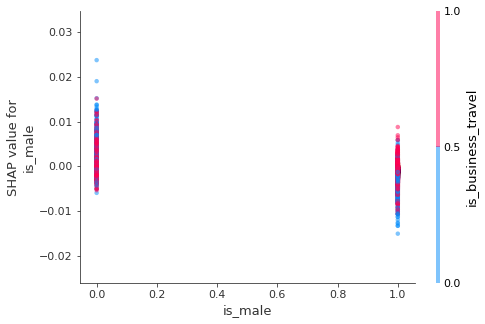

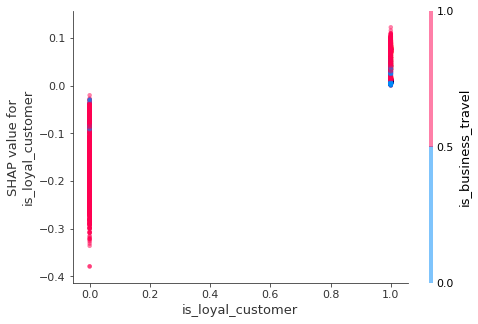

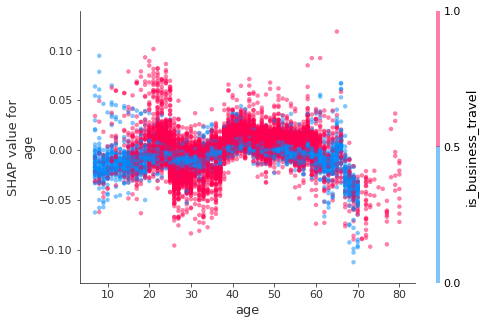

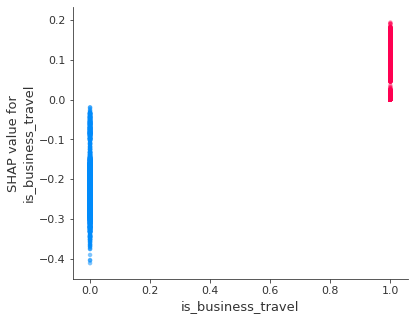

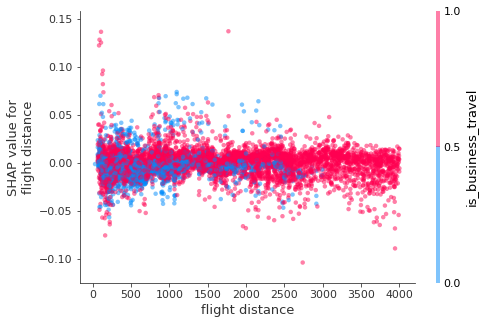

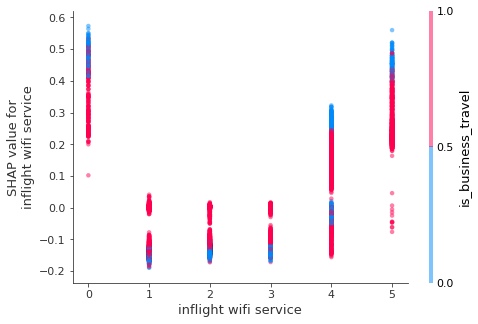

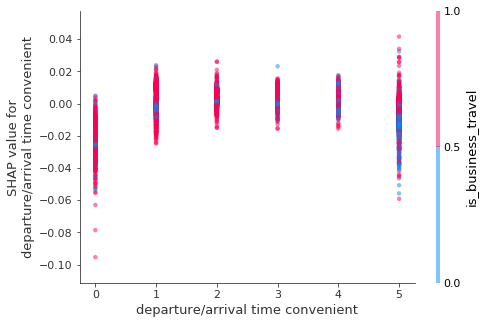

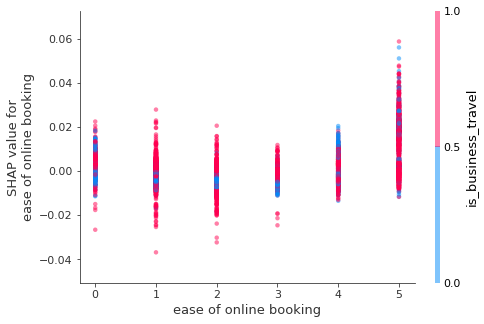

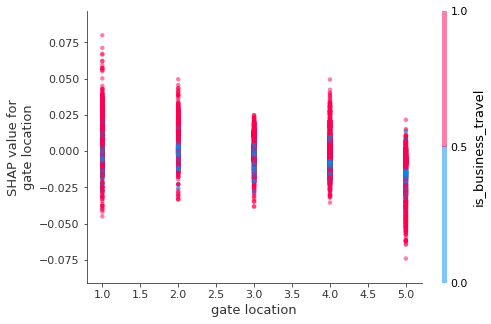

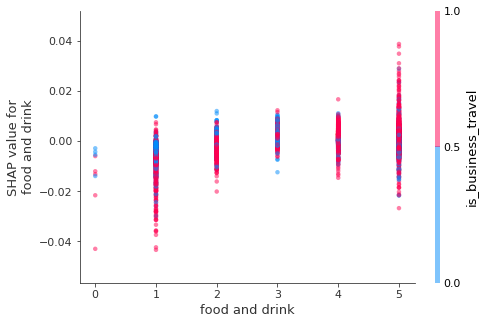

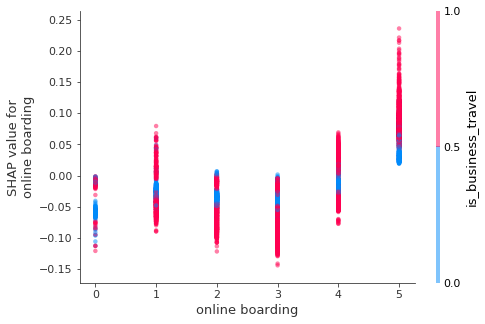

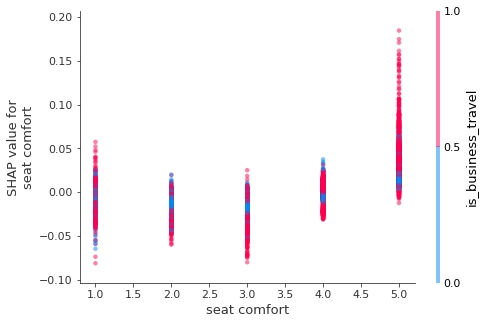

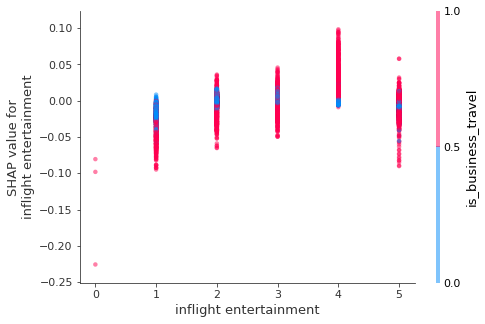

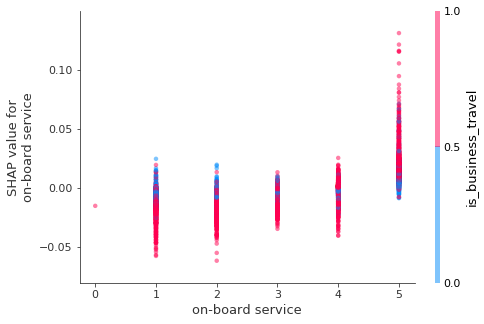

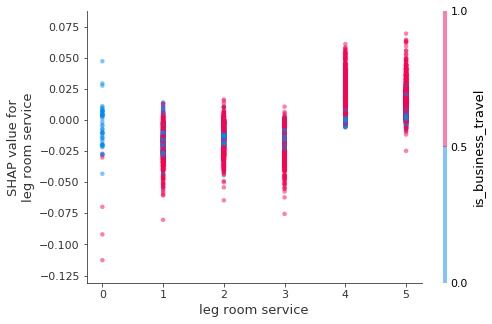

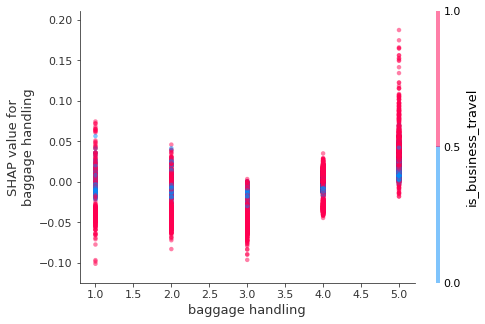

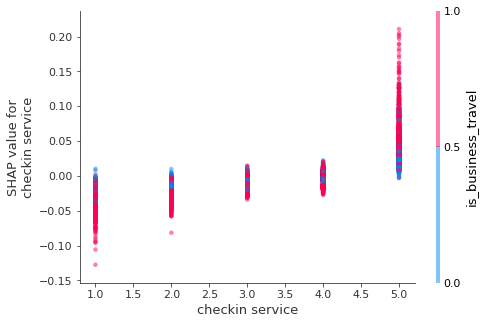

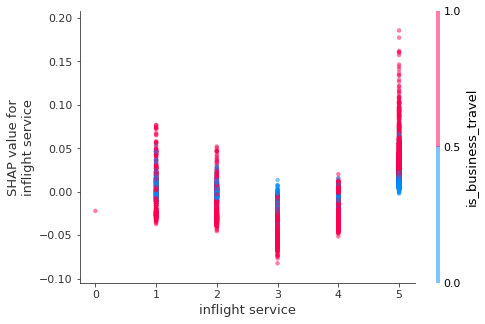

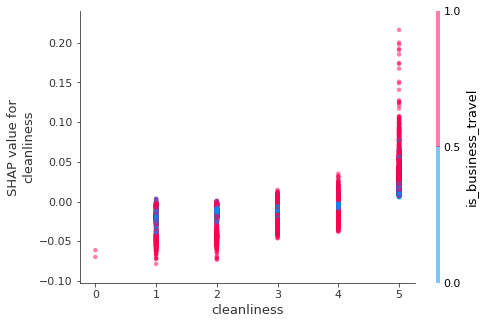

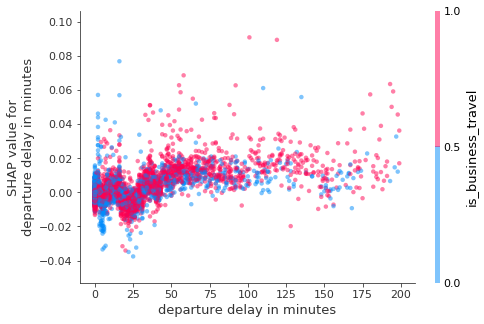

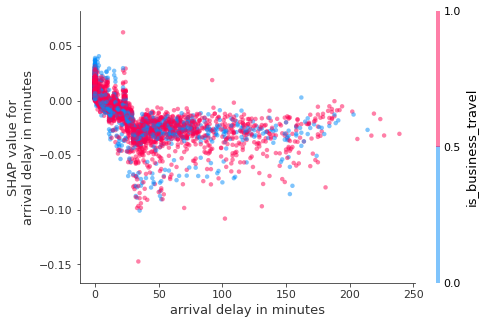

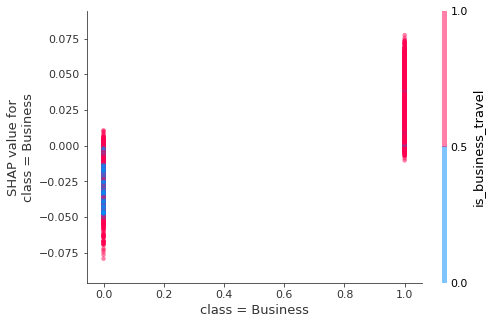

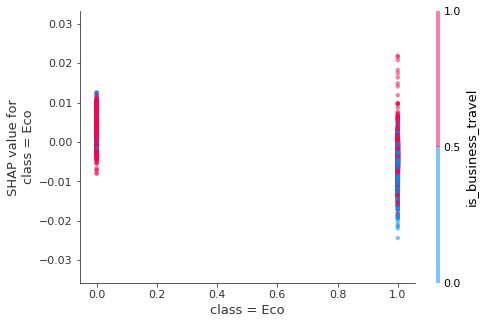

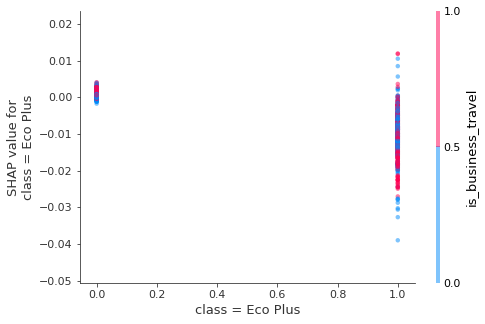

In [25]:
for name in X_train.columns:
    shap.dependence_plot(name, LGB_shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'is_business_travel')

#### 3. Prediction explanation plots

Visualize 1 or more prediction's explanation

#### High percentage explanation

In [39]:
shap.force_plot(LGB_explainer.expected_value, LGB_shap_values[485,:], X_train.iloc[485,:]) #plot_cmap=['#32CD32', '#B22222'])

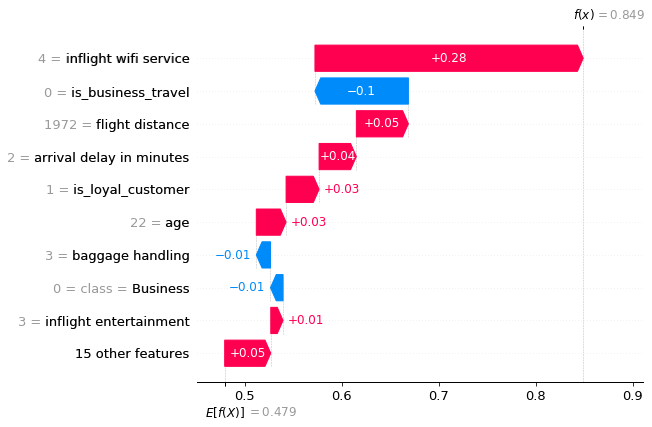

In [40]:
shap.plots._waterfall.waterfall_legacy(LGB_explainer.expected_value, LGB_shap_values[485, :], 
                                       features = X_train.iloc[485,:], )

#### Low percentage explanation

In [44]:
shap.force_plot(LGB_explainer.expected_value, LGB_shap_values[780,:], X_train.iloc[780,:]) #plot_cmap=['#32CD32', '#B22222'])

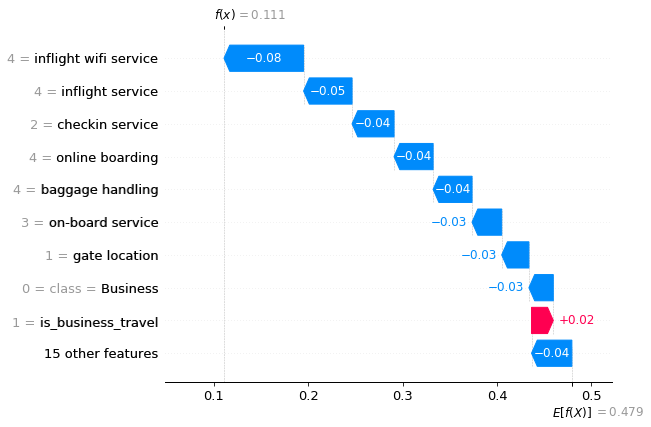

In [45]:
shap.plots._waterfall.waterfall_legacy(LGB_explainer.expected_value, LGB_shap_values[780, :], 
                                       features = X_train.iloc[780,:], )

In [46]:
shap.force_plot(LGB_explainer.expected_value, LGB_shap_values[0:100,:], X_train.iloc[0:100,:]) #plot_cmap=['#32CD32', '#B22222'])

Use decision plots

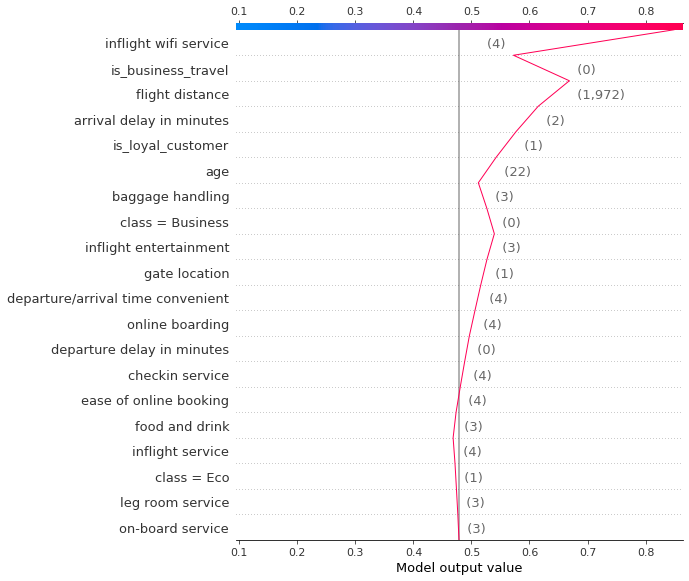

In [47]:
shap.decision_plot(LGB_explainer.expected_value, LGB_shap_values[485,:], 
                   features = X_train.iloc[485,:], )

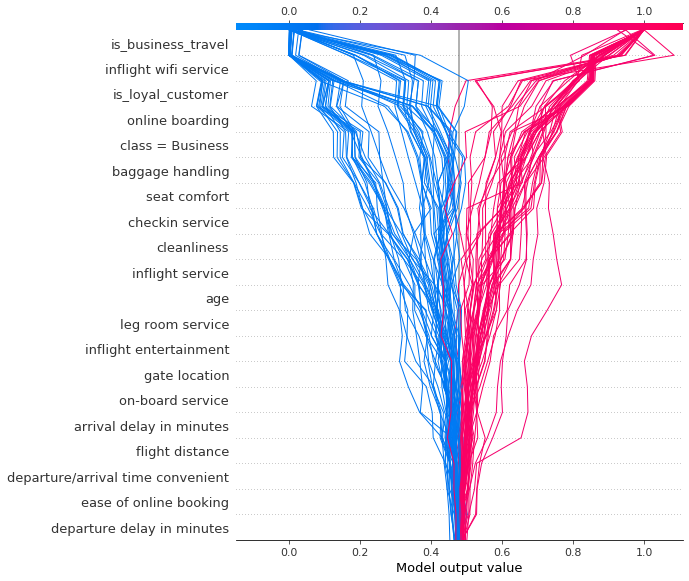

In [49]:
shap.decision_plot(LGB_explainer.expected_value, LGB_shap_values[0:100,:], 
                   features = X_train.iloc[0:100,:])